In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import sklearn.model_selection as model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [5]:
# import warnings
# warnings.filterwarnings('ignore')

In [6]:
# Read from extracted data
data = pd.read_csv('../data/flights_modeling_2022-10-26_2322.csv')

In [7]:
# Take copy to measure data loss after clean-up
model_rf = data.copy()

In [8]:
model_rf = model_rf.drop(columns=['mkt_carrier_fl_num', 'op_carrier_fl_num', 'dest_airport_id', 'dep_delay'])

In [9]:
model_rf.columns

Index(['origin_airport_id', 'arr_delay', 'crs_dep_time', 'crs_arr_time',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'distance',
       'month', 'fl_date_year', 'fl_date_week_number',
       'mean_dep_delay_carrier_origin_month',
       'mean_arr_delay_carrier_origin_month',
       'mean_dep_delay_carrier_origin_week',
       'mean_arr_delay_carrier_origin_week',
       'mean_dep_delay_carrier_origin_date',
       'mean_arr_delay_carrier_origin_date',
       'mean_dep_delay_carrier_origin_date_t-1_week',
       'mean_arr_delay_carrier_origin_date_t-1_week',
       'mean_dep_delay_carrier_origin_date_t-1_week_week_number',
       'mean_arr_delay_carrier_origin_date_t-1_week_week_number',
       'origin_region_Midwest', 'origin_region_Northeast',
       'origin_region_South', 'origin_region_West', 'dest_region_Midwest',
       'dest_region_Northeast', 'dest_region_South', 'dest_region_West',
       'arr_hrs_ctg_Afternoon', 'arr_hrs_ctg_Evening', 'arr_hrs_ctg_Morning',
 

#### Model

In [10]:
# Assign train and target variables
## Add columns to X
X = model_rf.drop('arr_delay', axis = 1)   # features
y = model_rf['arr_delay']    # labels

X_train,X_test,y_train,y_test = model_selection.train_test_split(X, y, train_size = 0.75, test_size = 0.25, random_state = 42)

In [11]:
display(model_rf.head(3))
display(model_rf.shape)

,origin_airport_id,arr_delay,crs_dep_time,crs_arr_time,crs_elapsed_time,actual_elapsed_time,air_time,distance,month,fl_date_year,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,haul_length_long,haul_length_medium,haul_length_short,cluster_km
0,11057,-16.0,2212,2341,89,76.0,57.0,370,3,2019,...,0,0,0,0,0,0,0,0,1,1
1,11057,3.0,2240,2353,73,83.0,45.0,241,3,2019,...,0,0,0,0,0,0,0,0,1,1
2,11057,10.0,1613,1713,60,62.0,34.0,191,3,2019,...,0,0,0,0,0,0,0,0,1,1


(563880, 48)

In [12]:
rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18)

In [13]:
# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=300,
                      random_state=18)

In [14]:
y_pred = rf.predict(X_test)

In [15]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 12.937266555151977


R2 Score for train data: 0.055
R2 Score2 for test data: 0.051
MAE Score for test data:  12.94


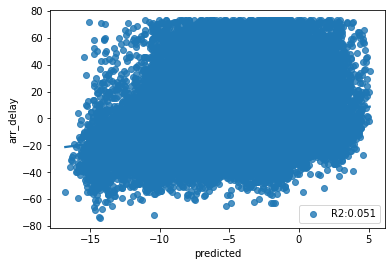

In [16]:
# Print the R2 score for the test dataset
print('R2 Score for train data:', round(rf.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'arr_delay':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='arr_delay',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

#### Random Forest Random Search

In [17]:
# Create the random grid
param_dist = {
    'n_estimators' : [10,15,100,150, 300],
    'max_features' : ['sqrt', 'log2'],
    'max_depth' : [5,8,10,12,15],
    'random_state' : [18]
}

In [18]:
# Instantiate RandomizedSearchCV, fit model, and make prediction
random_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions = param_dist)
random_rf.fit(X_train, y_train)
print('Best Score: ')
print(random_rf.best_score_)


Best Score: 
0.18169134157084293


In [19]:
y_pred = random_rf.predict(X_test)
df = pd.DataFrame(random_rf.cv_results_)

In [20]:
display(random_rf.best_params_)

# df.sort_values('rank_test_score', ascending = True).head(3)

{'random_state': 18,
 'n_estimators': 100,
 'max_features': 'sqrt',
 'max_depth': 15}

In [21]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 11.773646696031646


In [22]:
# Save the model
filename = 'Random_Forest.sav'
pickle.dump(random_rf,open(filename, 'wb'))